## White Balance Test

In [1]:
from pathlib import Path
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import cv2 as cv
import numpy as np
from tqdm import tqdm
from tqdm.contrib.concurrent import process_map, thread_map
from functools import partial
import concurrent.futures



%matplotlib notebook
%reload_ext autoreload
%autoreload 2

In [2]:
def show_image(im,  title=''):
    plt.imshow(im)
    plt.title(title)
    plt.xticks([]), plt.yticks([])  # Hides the graph ticks and x / y axis
    plt.show()

def read_images(path, is_BGR = False):
    gen = Path(path).rglob('*.png')
    image_paths = [str(img) for img in gen]
    image_paths = sorted(image_paths)
    images = []
    n_images = len(image_paths)
    for i in range(0, n_images):
#         print(f'reading from {image_paths[i]}')
        im = cv.imread(image_paths[i], -1)
        if is_BGR:
            im = cv.cvtColor(im, cv.COLOR_BGR2RGB)
        images.append(im)
    return images

def save_animation(images, out_file):
    fig = plt.figure(figsize=(8,6))
    ims = []
    n_images = len(images)
    for i in tqdm(range(0, n_images)):    
        plt_im = plt.imshow(images[i], animated=True)
        ims.append([plt_im])

    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                    repeat_delay=1000)
    ani.save(out_file)
    print(f'Saved animation to {out_file}')

In [3]:
dataroot = '/mnt/data/datasets/alice/debayered/'
grayworld_wb = dataroot + 'grayworld/'
automatic_corr = dataroot + 'automatic_corr/'
images = read_images(dataroot)
n_images = len(images)
print(f'Found {n_images} in path {dataroot}')

Found 1731 in path /mnt/data/datasets/alice/debayered/


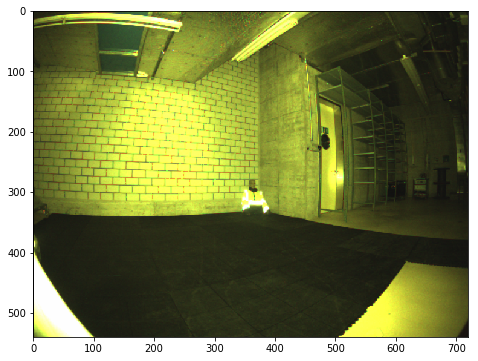

In [6]:
fig = plt.figure(figsize=(8,6))
ims = []
for i in range(0, n_images):
# i = 500
    im = cv.imread(image_paths[i], -1)
    plt_im = plt.imshow(im, animated=True)
    ims.append([plt_im])
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
ani.save('initial.mp4')

plt.show()

--------------------------------------------------
## OpenCV White Balance implementations

### Grayworld White Balance


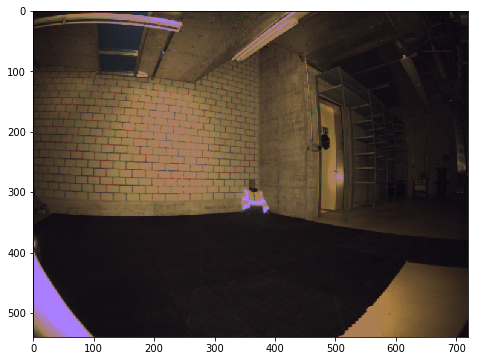

In [4]:
fig = plt.figure(figsize=(8,6))
ims = []
# Simple WB
# inst = cv.xphoto.createSimpleWB()

# Grayworld WB
# inst = cv.xphoto.createGrayworldWB()
# inst.setSaturationThreshold(0.7)

# Learning-based WB
inst = cv.xphoto.createLearningBasedWB('/mnt/data/datasets/alice/shi_gehler/color_balance_model.yml')
inst.setSaturationThreshold(0.95)
inst.setRangeMaxVal(165)
inst.setHistBinNum(128)

for i in range(0, n_images):
# i = 500   
    im_wb = inst.balanceWhite(images[i])
    
    plt_im = plt.imshow(im_wb, animated=True)
    ims.append([plt_im])
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)
ani.save('opencv_learning.mp4')
plt.show()

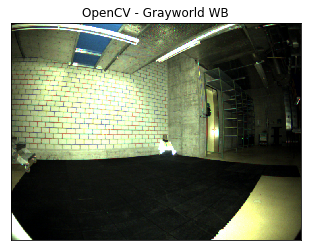

In [116]:
i = 4
im = images[i]

# Simple WB
inst = cv.xphoto.createSimpleWB()

# Grayworld WB
# inst = cv.xphoto.createGrayworldWB()
# inst.setSaturationThreshold(0.7)

# Learning-based WB
# inst = cv.xphoto.createLearningBasedWB('/mnt/data/datasets/alice/shi_gehler/color_balance_model.yml')
# inst.setSaturationThreshold(0.95)
# inst.setRangeMaxVal(165)
# inst.setHistBinNum(128)

im_wb = inst.balanceWhite(im)
show_image(im_wb, 'OpenCV - Grayworld WB')

## Learning-based White Balance

## Color Correct

In [5]:
from colorcorrect.algorithm import stretch, grey_world, retinex, retinex_with_adjust, max_white
from colorcorrect.algorithm import standard_deviation_weighted_grey_world
from colorcorrect.algorithm import standard_deviation_and_luminance_weighted_gray_world
from colorcorrect.algorithm import automatic_color_equalization
from colorcorrect.algorithm import luminance_weighted_gray_world

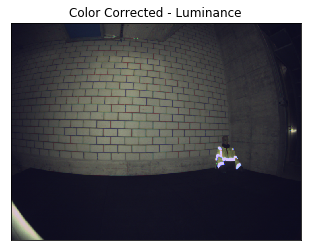

In [55]:
im = images[777]
# im_wb = automatic_color_equalization(im, 30, 30)
im_wb = standard_deviation_and_luminance_weighted_gray_world(im, 400, 10)
show_image(im_wb, 'Color Corrected - Luminance')

In [6]:
images_wb = [None] * n_images
img_idx = np.arange(0, n_images, 1)
ace = partial(automatic_color_equalization, slope=30, samples=500)
with concurrent.futures.ThreadPoolExecutor() as executor:
    for idx, im_wb in tqdm(zip(img_idx, executor.map(ace, images))):
        images_wb[idx] = im_wb                

1721it [21:21,  1.34it/s]


<Figure size 576x432 with 0 Axes>

In [56]:
images_wb = [None] * n_images
img_idx = np.arange(0, n_images, 1)
ace = partial(standard_deviation_and_luminance_weighted_gray_world, subwidth=400, subheight=10)
with concurrent.futures.ThreadPoolExecutor() as executor:
    for idx, im_wb in tqdm(zip(img_idx, executor.map(ace, images))):
        images_wb[idx] = im_wb
save_animation('cca_st_lw.mp4')

1721it [00:07, 227.20it/s]


100%|██████████| 1721/1721 [00:06<00:00, 255.75it/s]


Saved animation to srgb.mp4


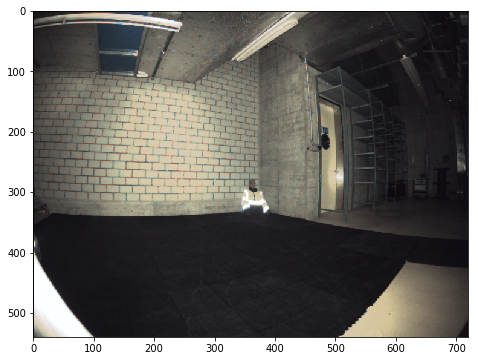

In [15]:
srgb_images = read_images('/mnt/data/datasets/alice/debayered_bgr/awb_srgb/', True)
save_animation(srgb_images, 'srgb.mp4')